In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [2]:
def update_state(c,b1,b2,g_0,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * g_0 * np.sqrt(omega_A/L) * np.exp(-1j * (omega_tab - omega_A) * t) 
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))


    c_new = b1[:,np.newaxis] @ np.conjugate(g_matrix[np.newaxis,:]) + np.conjugate(g_matrix[:,np.newaxis]) @ b2[np.newaxis,:] 
    b1_new = c @ g_matrix
    b2_new = g_matrix @ c

    return -1j* dt * c_new, -1j * dt * b1_new, -1j * dt * b2_new

<h1> RG Scheme </h1>

In [3]:
def RG_scheme(c_init, b1_init, b2_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): initial atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(omega_tab)
    c_array = np.zeros((nb_pts_time, 2*n_modes, 2*n_modes), dtype=complex)
    b1_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b2_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b1_array[0] = b1_init
    b2_array[0] = b2_init
    
    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b1_current = b1_array[i-1]
        b2_current = b2_array[i-1]

        c_new_k1, b1_new_k1, b2_new_k1 = update_state(c_current, b1_current, b2_current, g_0, omega_tab, omega_A, L, t, dt)
        c_new_k2, b1_new_k2, b2_new_k2 = update_state(c_current + c_new_k1/2, b1_current + b1_new_k1/2, b2_current + b2_new_k1/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b1_new_k3, b2_new_k3  = update_state(c_current + c_new_k2/2, b1_current + b1_new_k2/2, b2_current + b2_new_k2/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b1_new_k4, b2_new_k4 = update_state(c_current + c_new_k3, b1_current + b1_new_k3, b2_current + b2_new_k3, g_0, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b1_new = b1_current + (b1_new_k1 + 2*b1_new_k2 + 2*b1_new_k3 + b1_new_k4) / 6
        b2_new = b2_current + (b2_new_k1 + 2*b2_new_k2 + 2*b2_new_k3 + b2_new_k4) / 6

        c_array[i] = c_new
        b1_array[i] = b1_new
        b2_array[i] = b2_new

    return c_array, b1_array, b2_array 
    

<h1> Function that treats the whole evolution </h1>

In [4]:
def get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    overlap_tab (np array): Array of overlaps with the initial state.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_p) #only positive modes
    n_modes = len(k_tab_individual) #number of modes in each waveguide
    omega_tab_individual = np.abs(k_tab_individual)

    if print_info:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((2*n_modes, 2*n_modes), dtype=complex)
    b1_init = np.zeros(2*n_modes, dtype=complex)
    b2_init = np.zeros(2*n_modes, dtype=complex)


    c_a_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_0)
    c_a = np.concatenate((c_a_individual, np.zeros(n_modes))) #put it in the first waveguide

    c_b_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_1)
    c_b = np.concatenate((np.zeros(n_modes), c_b_individual)) #put it in the second waveguide

    c_init = c_a[:, np.newaxis] * c_b[np.newaxis, :]
    c_init = (c_init + c_init.T)
    norm = np.sqrt(np.sum(np.abs(c_init)**2))
    c_init /= norm

    ##evolve the state
    if print_info:
        print("Evolving the state...")
    c_array, b1_array, b2_array = RG_scheme(c_init, b1_init, b2_init, g_0, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b1_array, b2_array, k_tab_individual

<h1> First test </h1>

Some checks

In [15]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
omega_max = 20

omega_A_phys = 10
g_0_phys = 0.538

omega_0 = omega_A_phys + 1*g_0_phys**2 * omega_A_phys 

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma

x_0 = -L/4
delta_x = 0*sigma
x_1 = x_0 + delta_x

#check some parameters
gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("omega_0 = ", omega_0)
print("Physical bandwith is ", g_0_phys**2 * omega_A_phys, " and sigma momentum is ", sigma_momentum)

50% Reflectivity for omega_0_m =  7.5  and omega_0_p =  12.5
omega_0 =  12.89444
Physical bandwith is  2.8944400000000003  and sigma momentum is  0.5092958178940651


Run the calculations

In [16]:
c_array, b1_array, b2_array, k_tab_individual = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = True, progress_bar=True)

Number of modes:  101
Preparing the initial state...
Evolving the state...


  0%|          | 0/1569 [00:00<?, ?it/s]

<h1> Coherence and atom excitation </h1>

In [17]:
time_array = np.linspace(0, T, int(T / dt))
nb_pts_time = int(T / dt)
n_modes = c_array.shape[1] // 2

c_11 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_12 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_21 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_22 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)

p_11 = np.zeros(nb_pts_time)
p_12 = np.zeros(nb_pts_time)
p_21 = np.zeros(nb_pts_time)
p_22 = np.zeros(nb_pts_time)

atom_excitation = np.zeros(nb_pts_time)
#get the number of modes

for i in tqdm(range(nb_pts_time)):
    c_current, b1_current, b2_current = c_array[i], b1_array[i], b2_array[i]

    atom_excitation[i] = np.sum(np.abs(b1_current)**2) + np.sum(np.abs(b2_current)**2)
    p_11[i] = np.sum(np.abs(c_current[:n_modes, :n_modes])**2)
    p_12[i] = np.sum(np.abs(c_current[:n_modes, n_modes:])**2)
    p_21[i] = np.sum(np.abs(c_current[n_modes:, :n_modes])**2)
    p_22[i] = np.sum(np.abs(c_current[n_modes:, n_modes:])**2)

  0%|          | 0/1570 [00:00<?, ?it/s]

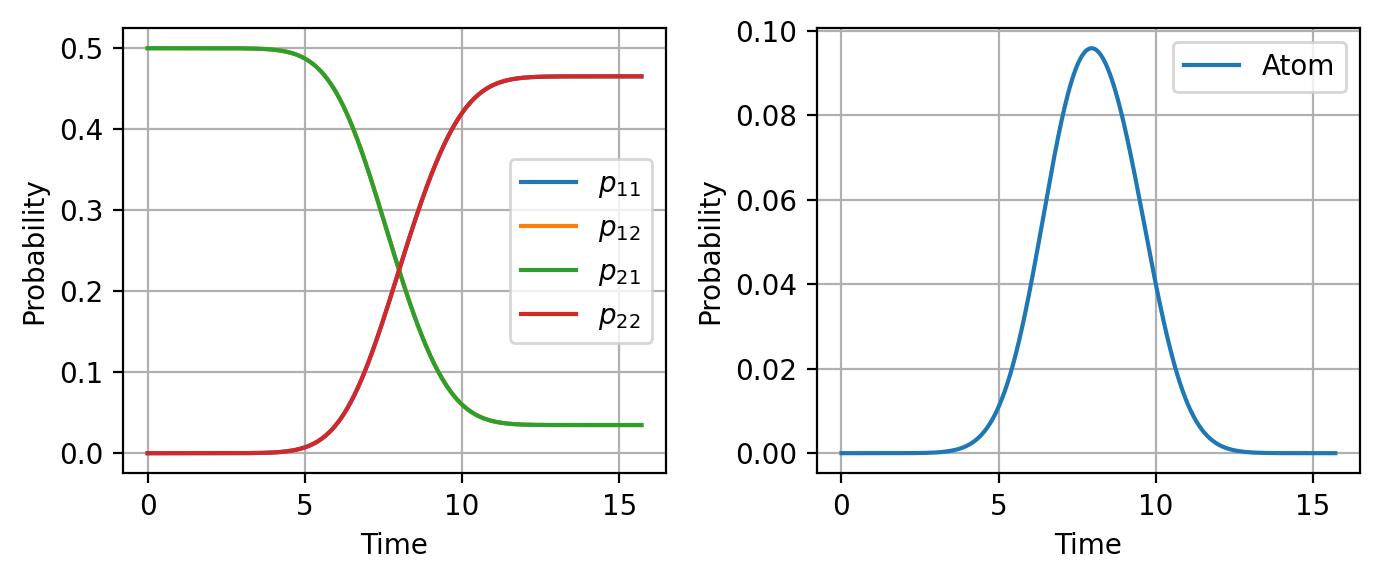

In [18]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=resol)

ax[0].plot(time_array, p_11, label="$p_{11}$")
ax[0].plot(time_array, p_12, label="$p_{12}$")
ax[0].plot(time_array, p_21, label="$p_{21}$")
ax[0].plot(time_array, p_22, label="$p_{22}$")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()
#ax[0].set_ylim([0,0.55])


ax[1].plot(time_array, atom_excitation,label='Atom')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].grid()
#ax[1].set_ylim([0,0.55])

fig.tight_layout()
plt.show()

Sanity check : HOM effect

In [19]:
#print("Final overlap: ", overlap_tab[-1])
print("anti HOM probability ", 1 - p_11[-1] - p_22[-1])
#print("Sanity check ", p_12[-1] + p_21[-1])
print("Theorytical value: ", 0.5 * (1 - np.exp(-0.5 * (np.abs(x_0 - x_1) / sigma)**2)))

anti HOM probability  0.06949643080030432
Theorytical value:  0.0


Visualize wave function in both channels

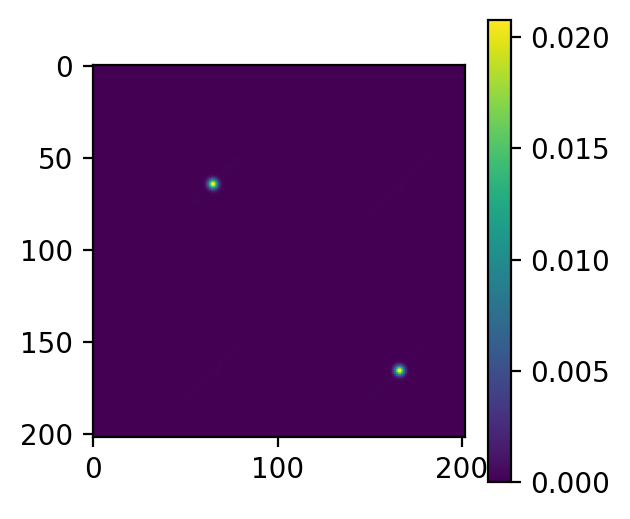

In [20]:
time_index = -1
c_current = c_array[time_index]
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
im = ax.imshow(np.abs(c_current)**2)
plt.colorbar(im, ax=ax)
plt.show()

<h1> Study the correlation between the 2 photons </h1>

First, get the probability distribution of both photons

In [21]:
time_index = -1
c_current = c_array[time_index]
p_joint = np.abs(c_current)**2

if np.sum(p_joint) < 0.999:
    print("Warning: p_joint not normalized properly")
    print(np.sum(p_joint))

n_modes = len(k_tab_individual)

p_photon_1 = np.sum(p_joint, axis=1)
p_photon_2 = np.sum(p_joint, axis=0)

k_tab_total = np.concatenate((k_tab_individual, k_tab_individual))
k_tab_axis = np.concatenate((k_tab_individual, 1 + np.max(k_tab_individual) + k_tab_individual))

#sanity check
for i in range(nb_pts_time):
    is_sym = np.allclose(p_joint, p_joint.T)
    if not is_sym:
        print(i)

Plot the probabilities

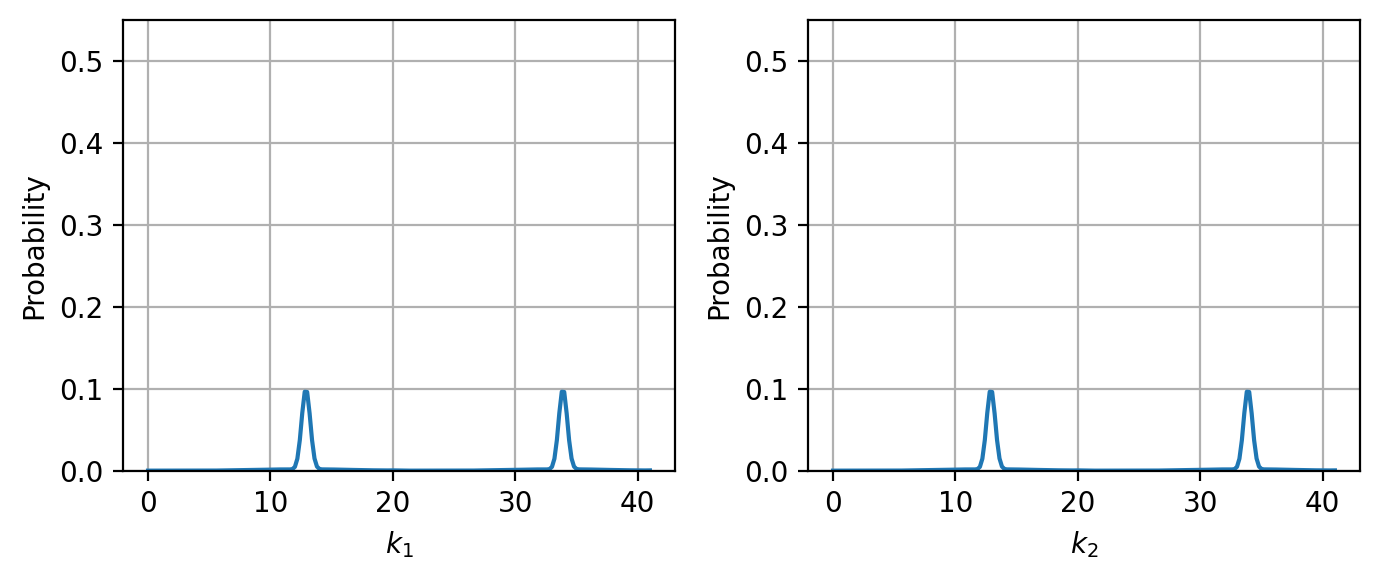

In [22]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=resol)

#labels = [f"{k:.2f}\n(ch1)" for k in k_tab_individual[::20]] + [f"{k:.2f}\n(ch2)" for k in k_tab_individual[::20]]
#x_axis_values = [k for k in k_tab_individual[::20]] + [k for k in k_tab_individual[::20]]

ax[0].plot(k_tab_axis, p_photon_1)
ax[0].set_xlabel('$k_1$')
ax[0].set_ylabel('Probability')
ax[0].grid()
ax[0].set_ylim([0,0.55])

ax[1].plot(k_tab_axis, p_photon_2)
ax[1].set_xlabel('$k_2$')
ax[1].set_ylabel('Probability')
ax[1].grid()
ax[1].set_ylim([0,0.55])

fig.tight_layout()
plt.show()

Try to compute a correlation coefficient

In [23]:
product_values = k_tab_total[:,np.newaxis] * k_tab_total[np.newaxis,:]

mean_photon_1 = np.sum(k_tab_total * p_photon_1)
mean_photon_2 = np.sum(k_tab_total * p_photon_2)
mean_product = np.sum(product_values * p_joint)

std_photon_1 = np.sqrt(np.sum((k_tab_total - mean_photon_1)**2 * p_photon_1))
std_photon_2 = np.sqrt(np.sum((k_tab_total - mean_photon_2)**2 * p_photon_2))

print("Correlation coefficient : ", (mean_product - mean_photon_1*mean_photon_2) / (std_photon_1*std_photon_2))

Correlation coefficient :  -0.9095444935618552


<h1>Evolution of the correlation coefficient</h1>

In [24]:
time_array = np.linspace(0, T, int(T / dt))
nb_pts_time = int(T / dt)
correlation_tab = np.zeros(nb_pts_time)

k_tab_total = np.concatenate((k_tab_individual, k_tab_individual))
product_values = k_tab_total[:,np.newaxis] * k_tab_total[np.newaxis,:]


for i in tqdm(range(nb_pts_time)):
    c_current = c_array[i]

    p_joint = np.abs(c_current)**2
    p_joint /= np.sum(p_joint)
    p_photon_1 = np.sum(p_joint, axis=1)
    p_photon_2 = np.sum(p_joint, axis=0)

    mean_photon_1 = np.sum(k_tab_total * p_photon_1)
    mean_photon_2 = np.sum(k_tab_total * p_photon_2)
    mean_product = np.sum(product_values * p_joint)

    std_photon_1 = np.sqrt(np.sum((k_tab_total - mean_photon_1)**2 * p_photon_1))
    std_photon_2 = np.sqrt(np.sum((k_tab_total - mean_photon_2)**2 * p_photon_2))

    correlation_tab[i] = (mean_product - mean_photon_1*mean_photon_2) / (std_photon_1 * std_photon_2)

    if correlation_tab[i] > 1:
        print(i)

  0%|          | 0/1570 [00:00<?, ?it/s]

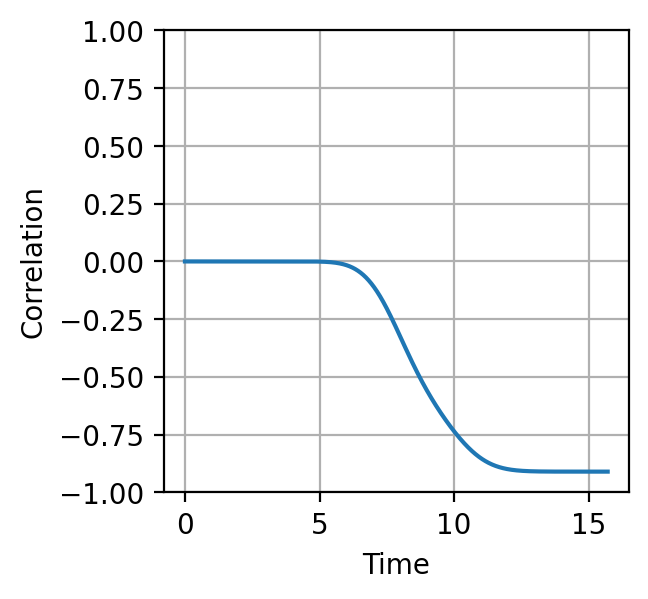

In [25]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

ax.plot(time_array, correlation_tab)
ax.set_xlabel("Time")
ax.set_ylabel("Correlation")
#ax.set_yscale("log")
ax.grid()
ax.set_ylim([-1,1])

plt.show()

<h1> HOM bunching probability </h1>

In [32]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
omega_max = 20

omega_A_phys = 10
g_0_phys = 0.538

omega_0 = omega_A_phys + 1*g_0_phys**2 * omega_A_phys 

#initial photon wavepacket parameters
sigma = L/50
sigma_momentum = 1/sigma
x_0 = -L/4

#prepare several values of delta_x
nb_pts_x = 9
delta_x_tab = np.linspace(-3*sigma, 3*sigma, nb_pts_x)
final_overlap_free_tab = np.zeros(nb_pts_x)
p_11_tab = np.zeros(nb_pts_x)
p_22_tab = np.zeros(nb_pts_x)

for i in tqdm(range(nb_pts_x)):
    delta_x = delta_x_tab[i]
    x_1 = x_0 + delta_x
    c_array, b1_array, b2_array, k_tab_individual  = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=False)
    p_11_tab[i] = np.sum(np.abs(c_array[-1, :n_modes, :n_modes])**2)
    p_22_tab[i] = np.sum(np.abs(c_array[-1, n_modes:, n_modes:])**2)


  0%|          | 0/9 [00:00<?, ?it/s]

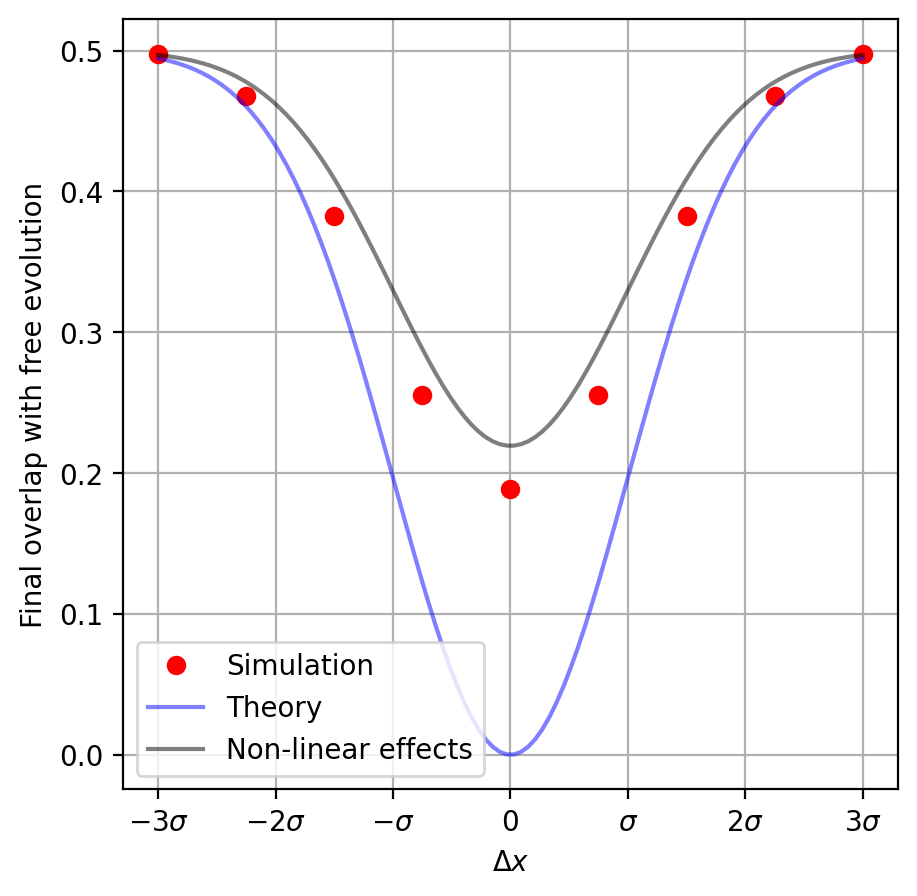

In [33]:
delta_x_theory = np.linspace(-3*sigma, 3*sigma, 100)
anti_HOM_proba_theory = 0.5*(1- np.exp(- (delta_x_theory**2) / (2*sigma**2)))

delta_anti_HOM_theory = 1 / (np.sqrt(2*pi) * sigma * g_0_phys**2 * omega_A_phys) * np.exp(- (delta_x_theory**2) / (2*sigma**2))


fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=resol)
ax.plot(delta_x_tab, 1-p_11_tab-p_22_tab, 'o', label="Simulation", color='red')
#ax.plot(delta_x_tab, final_overlap_free_tab, 'x', label="Old metric", color="green")
ax.plot(delta_x_theory, anti_HOM_proba_theory, label="Theory", color="blue", alpha=0.5)
ax.plot(delta_x_theory, anti_HOM_proba_theory + delta_anti_HOM_theory, label="Non-linear effects", color="black", alpha=0.5)

ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("Final overlap with free evolution")
ax.set_xticks(np.array([-3,-2, -1, 0, 1, 2, 3])*sigma)
ax.set_xticklabels([r"$-3\sigma$", r"$-2\sigma$", r"$-\sigma$", "0", r"$\sigma$", r"$2\sigma$", r"$3\sigma$"])
ax.grid()
ax.legend(loc="lower left")
plt.show()